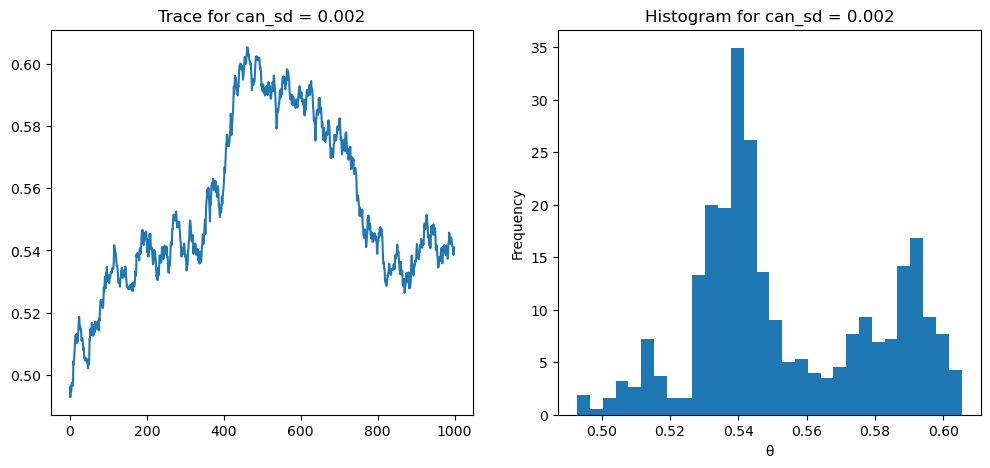

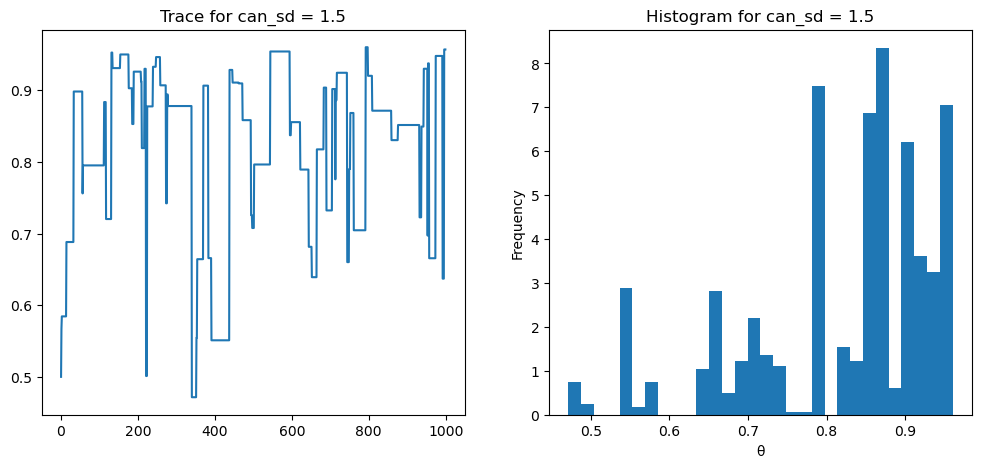

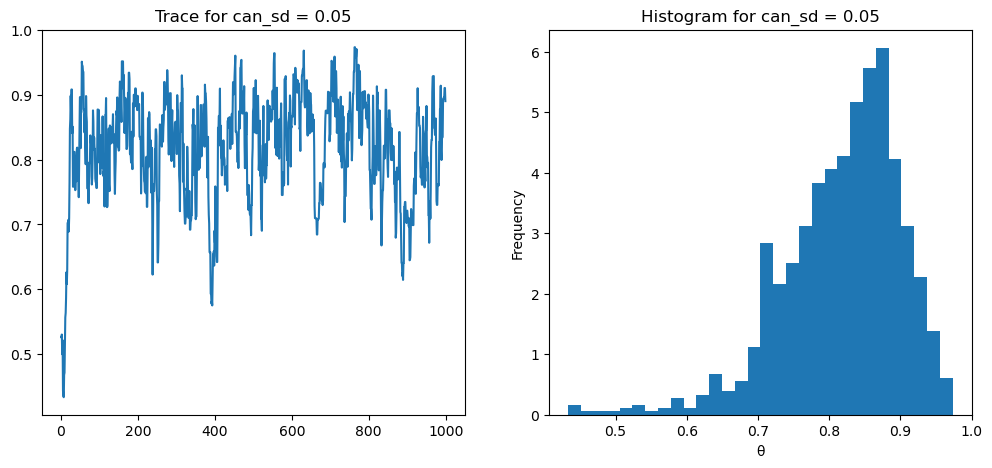

In [1]:
import numpy as np
import pandas as pd

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# posterior funct
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

Y = stats.bernoulli(0.7).rvs(20)

# Metropolis-Hastings sampler
def metropolis_hastings(can_sd, n_iters=1000):
    α = β = 1
    θ = 0.5
    trace = {"θ": np.zeros(n_iters)}
    p2 = post(θ, Y, α, β)

    for iter in range(n_iters):
        θ_can = stats.norm(θ, can_sd).rvs(1)
        p1 = post(θ_can, Y, α, β)
        pa = p1 / p2 if p2 != 0 else 0

        if pa > stats.uniform(0, 1).rvs(1):
            θ = θ_can
            p2 = p1

        trace["θ"][iter] = θ

    return trace["θ"]

# Different values of can_sd
sd_values = [0.002, 1.5, 0.05]  # Added 

# Run the sampler and plot the results
for sd in sd_values:
    trace = metropolis_hastings(sd)
    
    #plotting the trace
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(trace)
    plt.title(f'Trace for can_sd = {sd}')
    
    #plotting  histogram
    plt.subplot(122)
    plt.hist(trace, bins=30, density=True)
    plt.title(f'Histogram for can_sd = {sd}')
    plt.xlabel('θ')
    plt.ylabel('Frequency')
    plt.show()



Compared to what we can see in the textbook, we notice that for the graphs with can_sd = .002, it becomes clear that the pattern follows much less of a normal distribution than the graphs with can_sd = 0.05. Notably, with can_sd = .002, the trace plots show slow exploration, leading to a "random walk" behavior. We can see the graph exhibits high autocorrelation among consecutive samples because each new proposed value of θ is very close to the previous one. We see that there is also no convergence of any type appearing.

Looking at the graphs with can_sd = 1.5, a positive linear trend between frequency and theta can be observed, whereas more a bell-curve exists between the variables in the textbook graphs. The rapid fluctuation observed in the trace graph in the textbook also seems to indicate that the proposal distribution is proposing a diverse range of new θ values frequently. This could be a sign of effective mixing. On the other hand, the less rapid fluctuations with can_sd = 1.5 seem to indicate that with such a wide range in the proposal distribution, fewer candidate values are chosen. This can cause the Markov chain to miss areas of high probability and potentially lead to less efficient sampling of the parameter space.

Overall, can_sd = 0.05 seems to be the best choice of can_sd here as it efficiently samples the parameter space.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\addyg\AppData\Roaming\Python\Python310\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 1000x700 with 0 Axes>

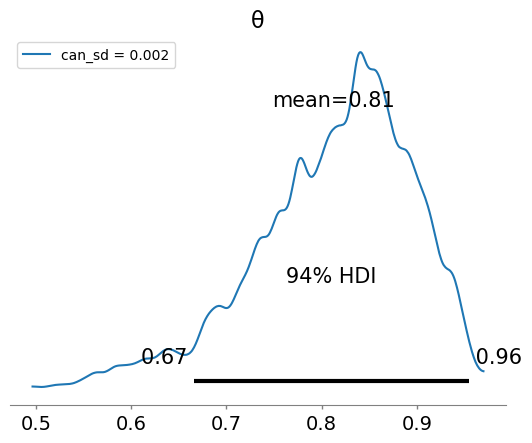

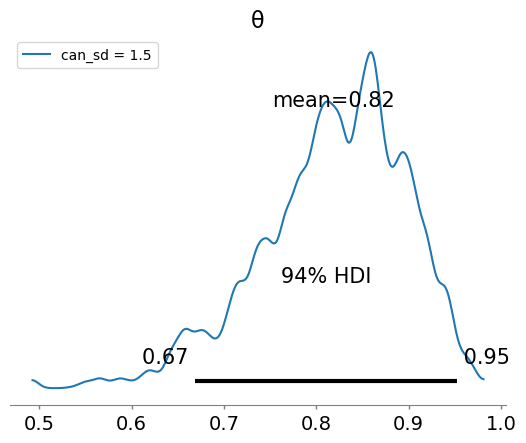

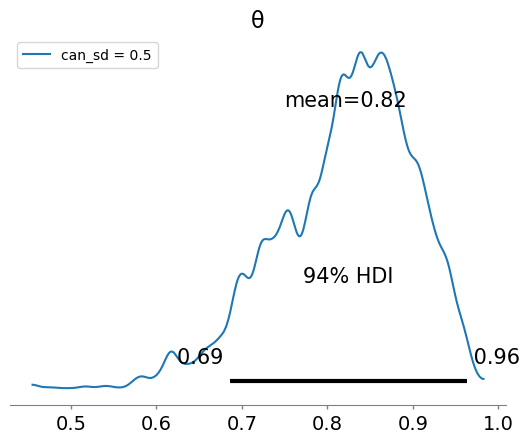

In [2]:
import pymc3 as pm
import arviz as az

sd_values = [0.002, 1.5, 0.5]  #the different can_sd values to consider
posterior_samples = {}

with pm.Model() as model:
    θ = pm.Beta("θ", alpha=1, beta=1)
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

    for sd in sd_values:
        step = pm.Metropolis(vars=[θ], S=np.array([[sd]]))  #metropolis step with desired can_sd
        trace = pm.sample(1000, step=step, return_inferencedata=False)
        posterior_samples[sd] = trace

        
plt.figure(figsize=(10, 7))

for sd in sd_values:
    az.plot_posterior(posterior_samples[sd], var_names=["θ"], hdi_prob=0.94, label=f"can_sd = {sd}")

plt.legend()
plt.show()


There aren't a lot of clear differences just based on these visual representations. They all have a mean of 0.68 94% HDI and similar ranges of theta shown. (can_sd = .002 with 0.5-0.85),(can_sd = 1.5 with 0.51-0.86) and (can_sd = 0.5 with 0.5-0.85). The only clear difference is that there is a "peak" of the distribution that is more cocnetrated for the lower values of can_sd, while the centre of the distribution for higher values of can_sd is less clear.

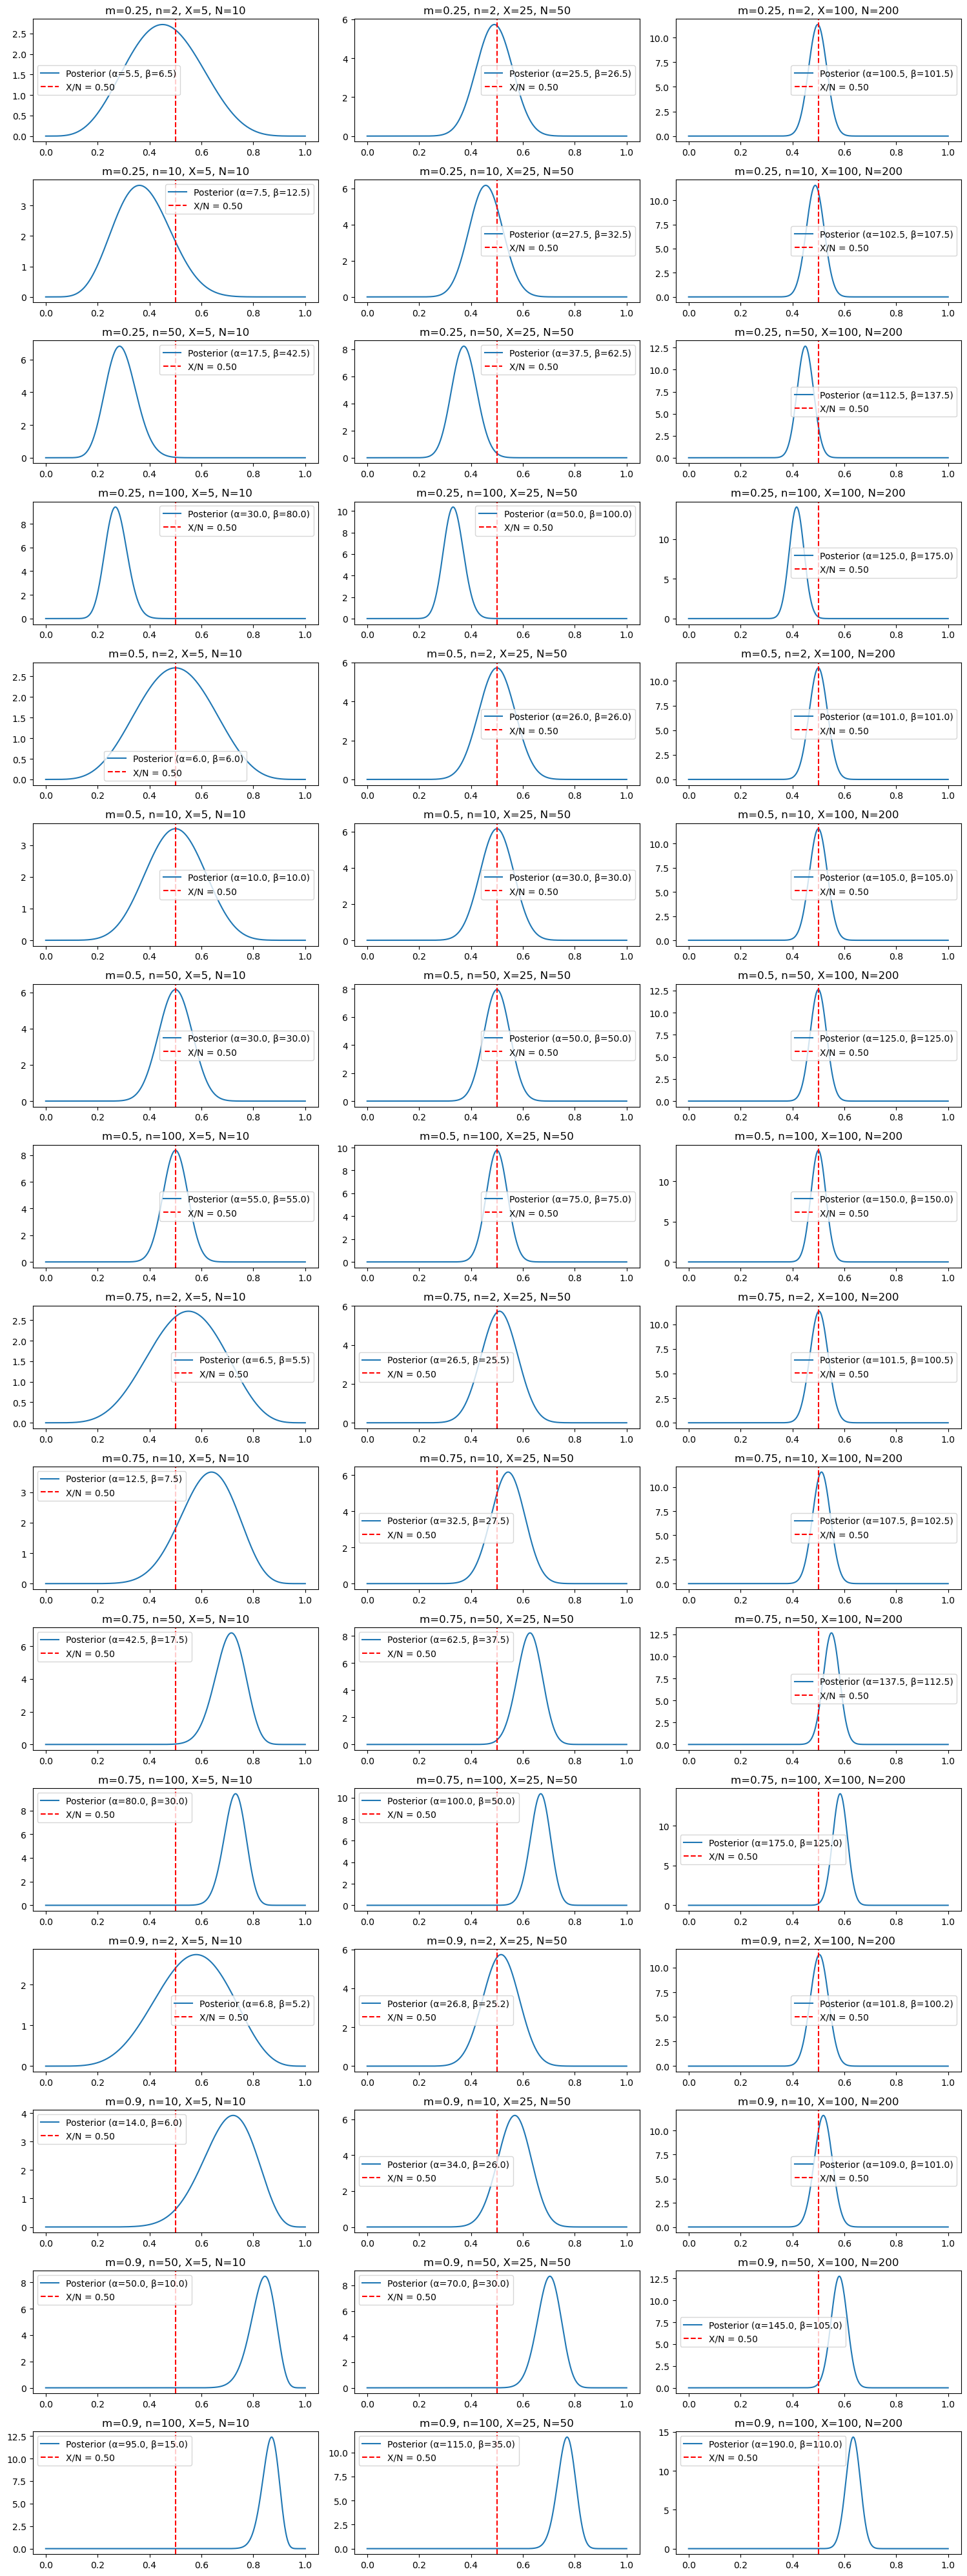

In [3]:

from scipy.stats import beta

# prior parameters
ms = [0.25, 0.5, 0.75, 0.9]
ns = [2, 10, 50, 100]

#frabricating the data
data = [(5, 10), (25, 50), (100, 200)]

#plots
fig, axs = plt.subplots(len(ms)*len(ns), len(data), figsize=(15, 40))

for i, (m, n) in enumerate([(m, n) for m in ms for n in ns]):
    alpha_prior = m * n
    beta_prior = n - alpha_prior

    for j, (X, N) in enumerate(data):
        ax = axs[i, j]

        # Compute posterior parameters
        alpha_post = alpha_prior + X
        beta_post = beta_prior + N - X

        # Generate beta distribution values
        x = np.linspace(0, 1, 1000)
        y = beta.pdf(x, alpha_post, beta_post)

        # Plot
        ax.plot(x, y, label=f'Posterior (α={alpha_post:.1f}, β={beta_post:.1f})')
        ax.axvline(X/N, color='red', linestyle='--', label=f'X/N = {X/N:.2f}')
        ax.set_title(f'm={m}, n={n}, X={X}, N={N}')
        ax.legend()

plt.tight_layout()
plt.show()


When alpha and beta are similar, higher values we can observe that the curve becomes very steep and concentrated toward the centre value of x. As the mean of the prior increases, the peak of the posterior distribution shifts towards the right. This is reflective of an initial belief that higher values of p (probability of success) are more likely. When m is small, the distribution is skewed towards larger p values, indicating a prior belief in a low probability of success.

N
Larger values of n make the prior distribution more peaked and narrow, indicating stronger confidence in the prior beliefs. The posterior will then be less influenced by the observed data.
Smaller n values result in flatter priors. The prior belief is weaker, and the posterior is more influenced by the observed data, leading to a wider spread in the posterior distribution.

Overall, Different combinations of m and n result in various shapes and peaks for the posterior distribution. A higher m with a larger n indicates a strong belief in a high probability of success, and vice versa. Different prior parameters (m and n) lead to varied shapes and peaks of the posterior distributions. The choice of these parameters should reflect the analyst's initial beliefs and confidence in those beliefs.
The size of the observed data (N) significantly impacts the posterior distribution. Larger N leads to a more defined and narrower posterior, indicating reduced uncertainty. The interaction between N and the prior "sample size" (n) determines the balance between prior beliefs and observed data in shaping the posterior

In [4]:
#load dataset
df = pd.read_csv('ArtHistBooks.csv')
print(df.head())

print("Unique values in 'ArtBooks':", df['ArtBooks'].unique())


data = df['ArtBooks'].values
trials = np.max(data)  # adjust as per the data

with pm.Model() as model:
    #using a Beta distribution as a prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    
    #using a Binomial distribution for the likelihood
    y = pm.Binomial('y', n=trials, p=theta, observed=data)
    
    #sampling from the posterior
    trace = pm.sample(500, tune=500)  

# mean posterior probability
print("\nPosterior probability:", np.mean(trace['theta']))


   ArtBooks  HistoryBooks  TableBooks  Purchase
0         0             0           1         0
1         0             1           0         0
2         0             0           0         0
3         1             0           1         0
4         1             1           1         0
Unique values in 'ArtBooks': [0 1 2 3]


C:\Users\addyg\AppData\Roaming\Python\Python310\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 668 seconds.
The acceptance probability does not match the target. It is 0.8849208718508953, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890115119237144, but should be close to 0.8. Try to increase the number of tuning steps.



Posterior probability: 0.1247180673632364


A posterior probability of 0.1247 means that, given the data and the non-informative prior, there is approx. a 12.47% chance that a customer will purchase the new book. 